In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
data = pd.read_csv(r"/content/amazon_alexa.tsv",  delimiter='\t', quoting=3)
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (3150, 5)


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [3]:
print(f"Featue names: {data.columns.values}")

Featue names: ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [4]:
data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [5]:
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [6]:
data.dropna(inplace=True)

In [7]:
print(f"Dataset shape after dropping null values: {data.shape}")

Dataset shape after dropping null values: (3149, 5)


In [8]:
data['length'] = data['verified_reviews'].apply(len)

In [9]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [10]:
print(f"'verified reviews'  column value: {data.iloc[10]['verified_reviews']}")
print(f"length of review: {len(data.iloc[10]['verified_reviews'])}")
print(f"'length' column value: {data.iloc[10]['length']}")

'verified reviews'  column value: "I sent it to my 85 year old Dad, and he talks to it constantly."
length of review: 65
'length' column value: 65


In [11]:
data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
length,int64


In [12]:
len(data)

3149

In [13]:
print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

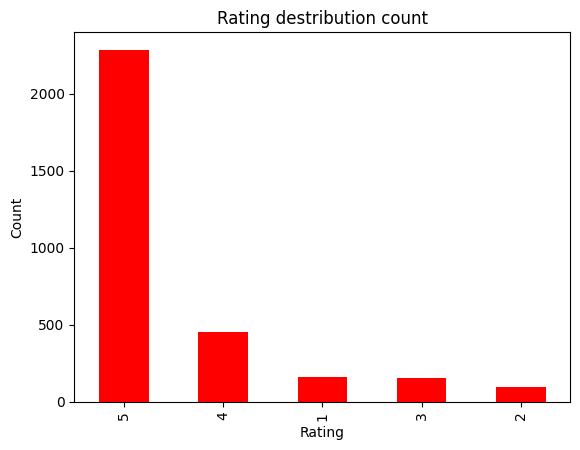

In [14]:
data['rating'].value_counts().plot.bar(color = 'red')
plt.title('Rating destribution count')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show

In [15]:
print(f"Rating value count - percentage destribution: \n{round(data['rating'].value_counts()/data.shape[0]*100, 2)}")

Rating value count - percentage destribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


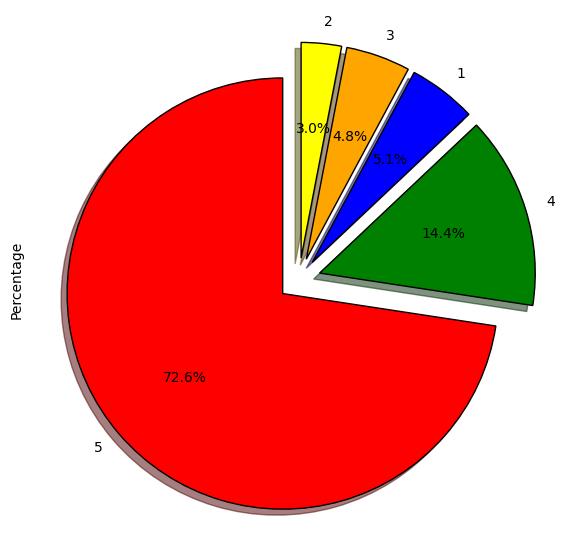

In [16]:
fig = plt.figure(figsize=(7, 7))
colors = ('red', 'green', 'blue', 'orange', 'yellow')
wp = {'linewidth':1, 'edgecolor':'black'}
tags = data['rating'].value_counts()/data.shape[0]
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage')

from io import BytesIO

graph = BytesIO()
fig.savefig(graph, format='png')

In [17]:
print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


In [18]:
review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [19]:
review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


<function matplotlib.pyplot.show(close=None, block=None)>

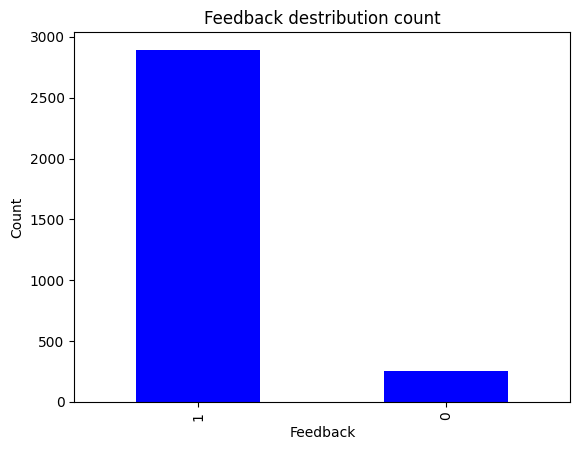

In [20]:
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback destribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show

In [21]:
print(f"Rating value count - percentage destribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100, 2)}")

Rating value count - percentage destribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


<Axes: ylabel='Percentage'>

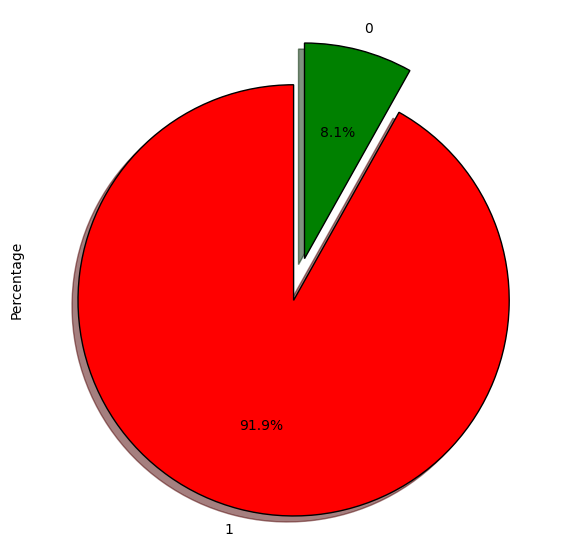

In [22]:
fig = plt.figure(figsize=(7, 7))
colors = ('red', 'green')
wp = {'linewidth':1, 'edgecolor':'black'}
tags = data['feedback'].value_counts()/data.shape[0]
explode = (0.1, 0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage')


In [23]:
data[data['feedback'] == 0]['rating'].value_counts()

,count
rating,
1,161
2,95


In [24]:
data[data['feedback'] == 1]['rating'].value_counts()

,count
rating,
5,2286
4,455
3,152


In [25]:
print(f"Variation value count: \n{data['variation'].value_counts()}")

Variation value count: 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


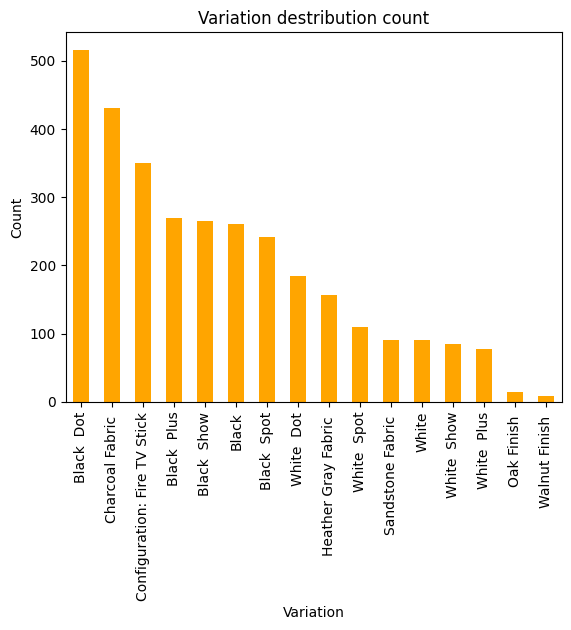

In [26]:
data['variation'].value_counts().plot.bar(color = 'orange')
plt.title('Variation destribution count')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.show()

In [27]:
print(f"Rating value count - percentage destribution: \n{round(data['variation'].value_counts()/data.shape[0]*100, 2)}")

Rating value count - percentage destribution: 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [28]:
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


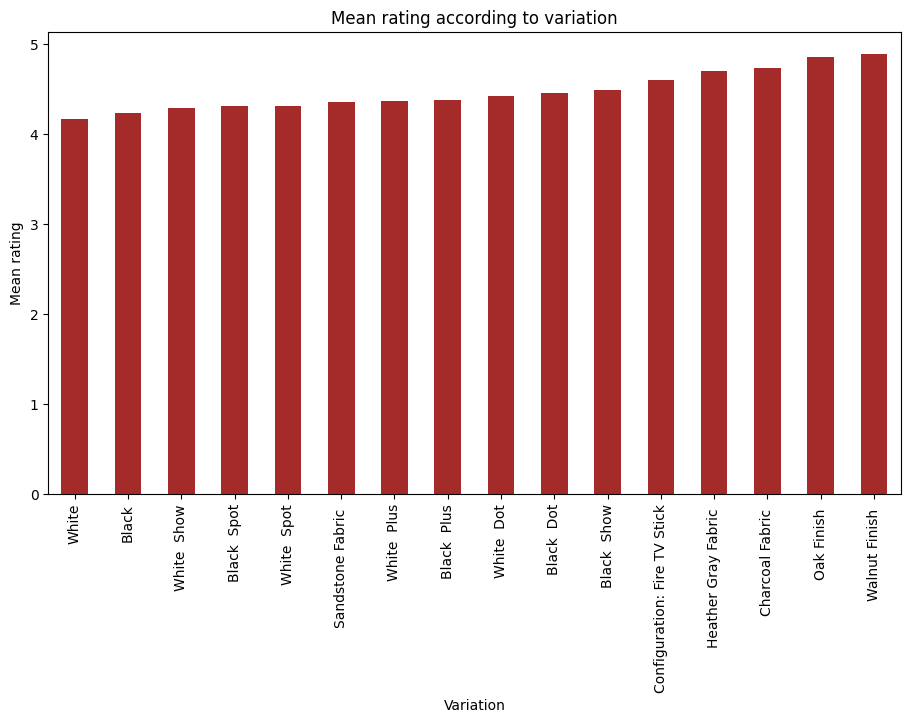

In [29]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color = 'brown', figsize=(11, 6))
plt.title('Mean rating according to variation')
plt.xlabel('Variation')
plt.ylabel('Mean rating')
plt.show()

In [30]:
data['length'].describe()

,length
count,3149.000000
mean,132.714513
std,182.541531
min,1.000000
25%,30.000000
50%,74.000000
75%,166.000000
max,2853.000000


[Text(0.5, 1.0, 'Destribution of length of reviews')]

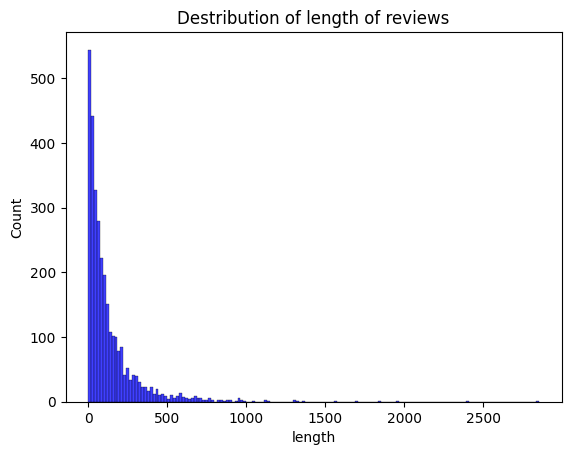

In [31]:
sns.histplot(data['length'], color='blue').set(title='Destribution of length of reviews')

[Text(0.5, 1.0, 'Destribution of length of review if feedback = 0')]

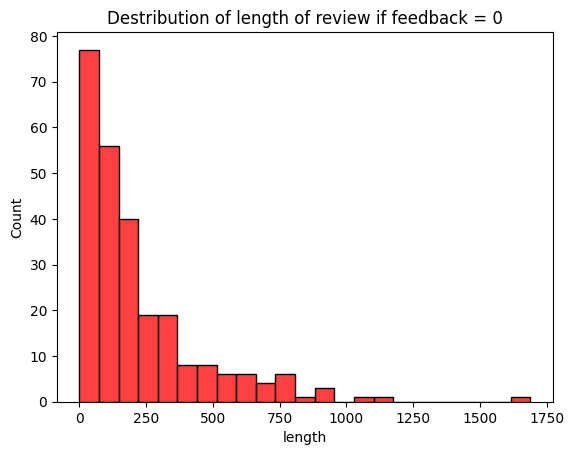

In [32]:
sns.histplot(data[data['feedback']==0]['length'], color='red').set(title='Destribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Destribution of length of review if feedback = 1')]

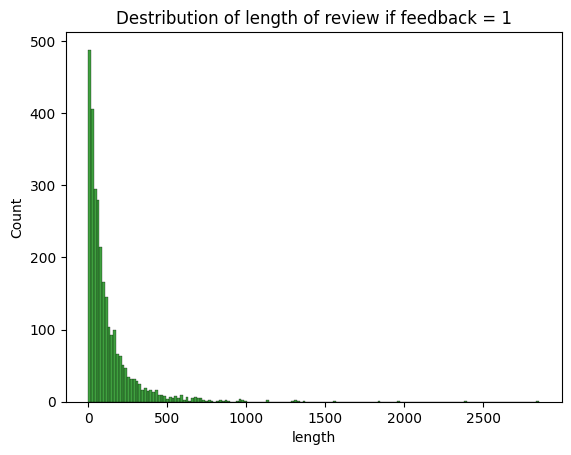

In [33]:
sns.histplot(data[data['feedback']==1]['length'], color='green').set(title='Destribution of length of review if feedback = 1')

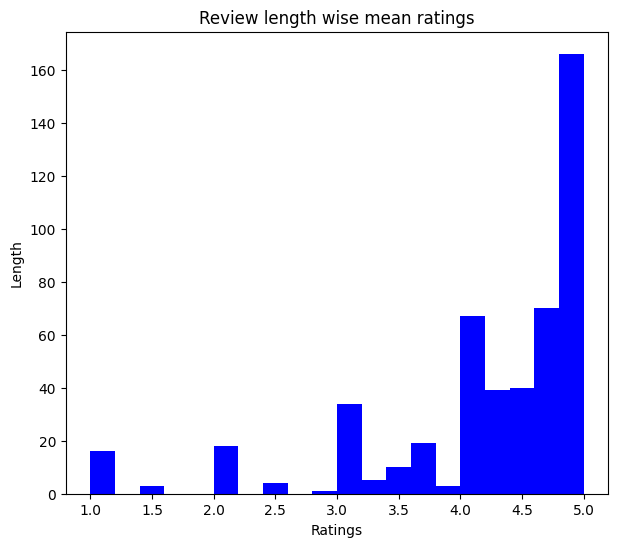

In [34]:
data.groupby('length')['rating'].mean().plot.hist(color='blue', figsize=(7, 6), bins=20)
plt.title('Review length wise mean ratings')
plt.xlabel('Ratings')
plt.ylabel('Length')
plt.show()

In [35]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(data.verified_reviews)

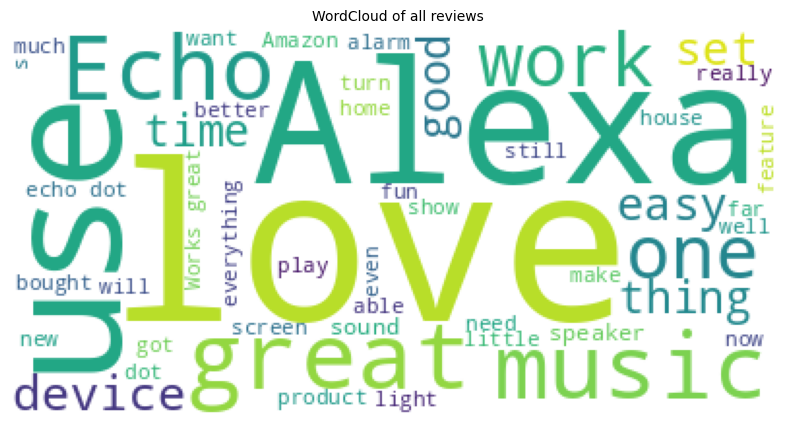

In [36]:
reviews = " ".join([review for review in data['verified_reviews']])

wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10, 10))
plt.imshow(wc.generate(reviews))
plt.title('WordCloud of all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [37]:
neg_reviews = " ".join([review for review in data[data['feedback']==0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback']==1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

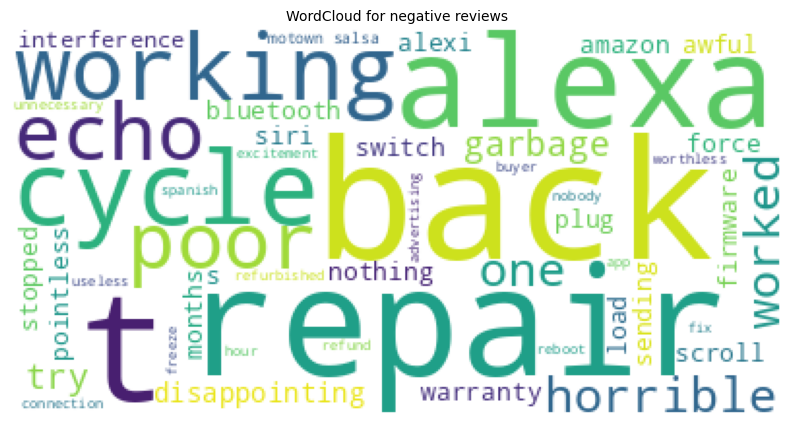

In [38]:
wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10, 10))
plt.imshow(wc.generate(unique_negative))
plt.title('WordCloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

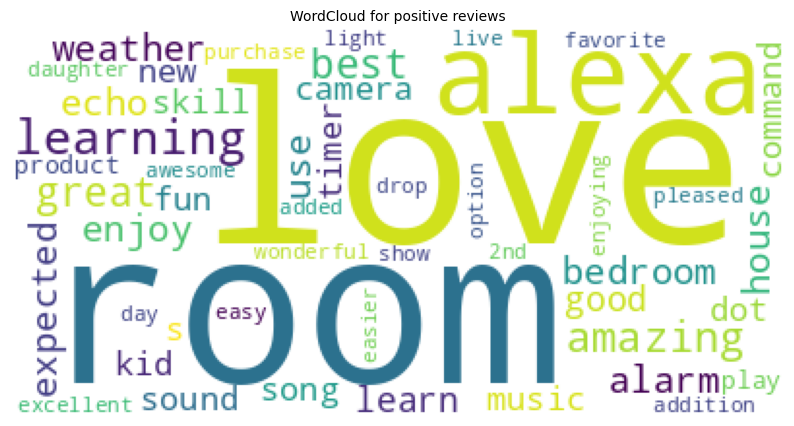

In [39]:
wc = WordCloud(background_color='white', max_words=50)

plt.figure(figsize=(10, 10))
plt.imshow(wc.generate(unique_positive))
plt.title('WordCloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

In [40]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower()
  review = review.split()
  review = [stemmer.stem(word) for word in review if not word in set(STOPWORDS)]
  review = ' '.join(review)
  corpus.append(review)

In [41]:
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [42]:
pickle.dump(cv, open('/content/CountVectorizer.pkl', 'wb'))

In [43]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3149, 2500)
y shape: (3149,)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2204, 2500)
X_test shape: (945, 2500)
y_train shape: (2204,)
y_test shape: (945,)


In [45]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 10


In [46]:
scaler = MinMaxScaler()
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [47]:
pickle.dump(scaler, open('/content/MinMaxScaler.pkl', 'wb'))

In [48]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [49]:
print(f"Training accuracy: {model_rf.score(X_train_scl, y_train)}")
print(f"Testing accuracy: {model_rf.score(X_test_scl, y_test)}")

Training accuracy: 0.9945553539019963
Testing accuracy: 0.944973544973545


In [50]:
y_preds = model_rf.predict(X_test_scl)

In [51]:
cm = confusion_matrix(y_test, y_preds)


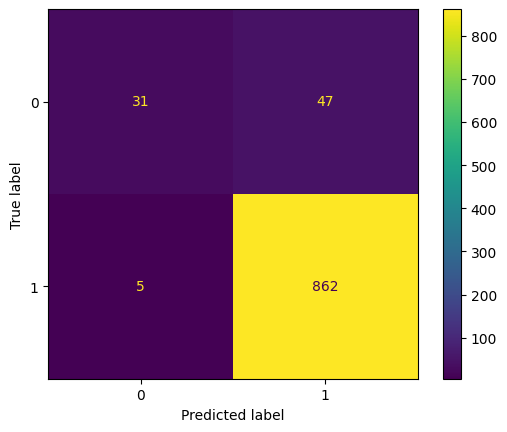

In [52]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [53]:
accuracy = cross_val_score(estimator=model_rf, X=X_train_scl, y=y_train, cv=10)
print(f"Accuracy: {accuracy.mean()}")
print(f"Standard deviation: {accuracy.std()}")

Accuracy: 0.9324002468120115
Standard deviation: 0.009146860814864176


In [55]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [56]:
cv_object = StratifiedKFold(n_splits=2)
grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv=cv_object, verbose=0, return_train_score=True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [58]:
print("Best parameter combination: {}".format(grid_search.best_params_))

Best parameter combination: {'bootstrap': True, 'max_depth': 80, 'min_samples_split': 8, 'n_estimators': 100}


In [59]:
print("Cross validation mean accuracy on train set: {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set: {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set: ", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set: 96.75589836660617
Cross validation mean accuracy on test set: 92.13362068965517
Accuracy score for test set:  0.944973544973545


In [67]:
pip install scikit-learn==1.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [80]:
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from types import SimpleNamespace

class XGBWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = XGBClassifier(**kwargs)

    def fit(self, X, y):
        # Fit the underlying XGBClassifier
        self.model.fit(X, y)
        # Set the fitted attribute to indicate that the model is fitted
        self.is_fitted_ = True
        # Set the classes_ attribute (required for classifiers)
        self.classes_ = self.model.classes_
        return self

    def predict(self, X):
        check_is_fitted(self)  # Ensure the model is fitted
        return self.model.predict(X)

    def predict_proba(self, X):
        check_is_fitted(self)  # Ensure the model is fitted
        return self.model.predict_proba(X)

    def score(self, X, y):
        check_is_fitted(self)  # Ensure the model is fitted
        return self.model.score(X, y)

    def _get_tags(self):
        return SimpleNamespace(
            requires_y=True,
            non_deterministic=False,
            requires_positive_X=False,
            requires_positive_y=False,
            X_types=["2darray"],
            poor_score=False,
            no_validation=False,
            multioutput=False,
            allow_nan=True,
            stateless=False,
            multilabel=False,
            _skip_test=False,
            _xfail_checks=False,
            multioutput_only=False,
            binary_only=False,
            requires_fit=True,
        )

    def __sklearn_tags__(self):
        return self._get_tags()

# Use the wrapper class
model_xgb = XGBWrapper()
model_xgb.fit(X_train_scl, y_train)

XGBWrapper()

In [81]:
# Create an instance of the wrapper
model_xgb = XGBWrapper()

# Fit the model on the training data
model_xgb.fit(X_train_scl, y_train)

# Evaluate the model
print(f"Print training accuracy: {model_xgb.score(X_train_scl, y_train)}")
print(f"Print testing accuracy: {model_xgb.score(X_test_scl, y_test)}")

Print training accuracy: 0.971415607985481
Print testing accuracy: 0.9417989417989417


In [82]:
y_preds = model_xgb.predict(X_test)

In [83]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 31  47]
 [ 13 854]]


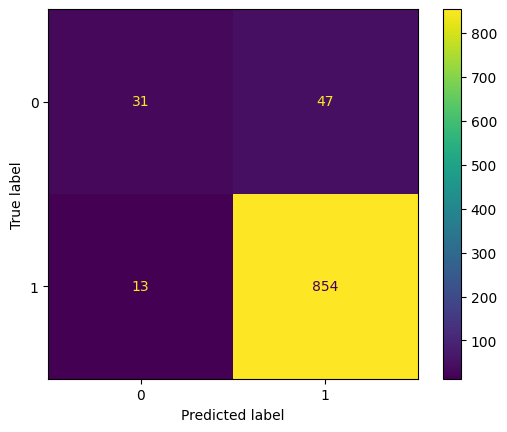

In [84]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [85]:
pickle.dump(model_xgb, open('/content/XGBWrapper.pkl', 'wb'))

In [86]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [87]:
print(f"Training accuracy: {model_dt.score(X_train_scl, y_train)}")
print(f"Testing accuracy: {model_dt.score(X_test_scl, y_test)}")

Training accuracy: 0.9945553539019963
Testing accuracy: 0.9206349206349206


In [88]:
y_preds = model_dt.predict(X_test)

In [89]:
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 42  36]
 [ 80 787]]


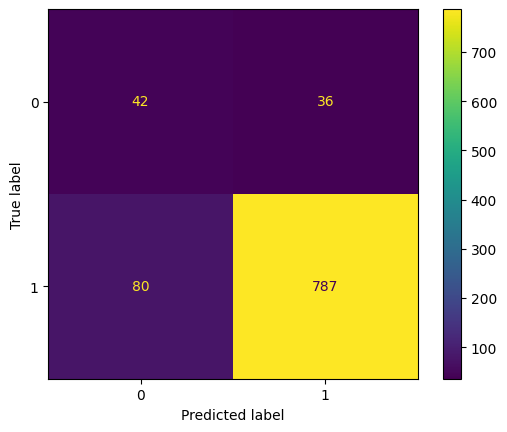

In [90]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
cm_display.plot()
plt.show()